In [134]:
import json
import os
import seaborn as sns
import numpy as np
import pandas as pd

test_dir = "/home/cynthiachen/il-representations/runs/il_test_runs/14"
eval_files = [os.path.join(test_dir, f) for f in os.listdir(test_dir) if 'eval' in f]
eval_files.sort()

with open(os.path.join(test_dir, 'config.json')) as f:
    test_config = json.load(f)
    
benchmark_name = test_config['env_cfg']['task_name']
policy_dir = test_config['policy_dir']

if policy_dir[-1] == '/':
    policy_dir = os.path.dirname(policy_dir)

train_config_file = os.path.join(os.path.dirname(policy_dir), 'config.json')

with open(train_config_file) as f:
    train_config = json.load(f)
    
train_exp_ident = train_config['exp_ident']
if train_exp_ident == 'dmc-full-trajs-consistent-augs':
    if train_config['bc']['n_trajs']:
        train_exp_ident = f"dmc-{train_config['bc']['n_trajs']}-trajs-consistent-augs"

print(train_exp_ident)
print(benchmark_name)
print(policy_dir)

dmc-30-trajs-consistent-augs
finger-spin
/scratch/cynthiachen/ilr-results/dmc-consistent-augs-2021-05-25/il_train/2/snapshots


## Plot return curves

[252.97, 480.06, 624.63, 544.11, 532.23, 625.29, 718.98, 745.82, 766.55, 741.69, 790.55, 619.12, 849.09, 866.93, 859.85, 868.73, 856.27, 848.51, 860.09, 871.83] [12500, 125000, 237500, 337500, 450000, 562500, 675000, 787500, 887500, 1000000, 1112500, 1225000, 1325000, 1437500, 1550000, 1662500, 1775000, 1875000, 1987500, 2100000]
[0, 1, 12, 13, 14, 15, 16, 17, 18, 19, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]


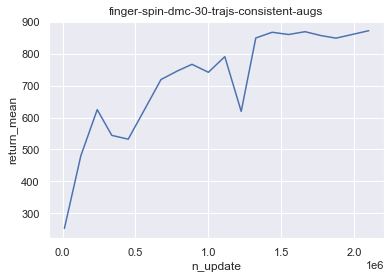

In [135]:
def get_mean_nupdate_list(eval_files):
    mean_list = []
    nupdate_list = []
    for eval_file in eval_files:
        with open(eval_file) as f:
            test_result = json.load(f)
        mean_list.append(test_result['return_mean'])
        policy_name = test_result['policy_path'].split('/')[-1]
        nupdate = int(policy_name.split('_')[-2])
        nupdate_list.append(nupdate)
    return mean_list, nupdate_list

mean_list, nupdate_list = get_mean_nupdate_list(eval_files)

# The lists might not be sorted according to nupdates, so we make sure
# they are sorted correctly here.
sorted_idx = sorted(range(len(nupdate_list)), key=lambda k: nupdate_list[k])
mean_list = [mean_list[idx] for idx in sorted_idx]
nupdate_list = [nupdate_list[idx] for idx in sorted_idx]

mean_dict = {'return_mean': mean_list, 'n_update': nupdate_list}
mean_df = pd.DataFrame(mean_dict)

sns.set(style='darkgrid')
ax = sns.lineplot(x='n_update', y='return_mean', data=mean_df)
ax.set_title(f"{benchmark_name}-{train_exp_ident}")

fig = ax.get_figure()
fig.savefig(f"{test_dir}/return_curve.png")

print(mean_list, nupdate_list)
print(sorted_idx)

## Plot loss curves

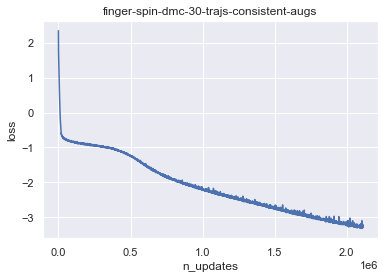

In [136]:
from pathlib import Path
train_folder = Path(policy_dir).parent.absolute()
progress_path = os.path.join(train_folder, 'progress.csv')
progress_df = pd.read_csv(progress_path)

ax = sns.lineplot(x='n_updates', y='loss', data=progress_df)
ax.set_title(f"{benchmark_name}-{train_exp_ident}")

fig = ax.get_figure()
fig.savefig(f"{test_dir}/loss_curve.png")

# Plot test variant results (MAGICAL)

In [101]:
def collect_magical_df(eval_files):
    initialize_test_entry = False
    result_dict = {}
    result_dict['n_update'] = []
    result_dict['return_mean'] = []
    
    for eval_file in eval_files:
        with open(eval_file) as f:
            test_result = json.load(f)
        if not initialize_test_entry:
            test_envs = [d['test_env'].split('-')[1] for d in test_result['full_data']]
            for env in test_envs:
                result_dict[env] = []
            initialize_test_entry = True
        for env_result in test_result['full_data']:
            test_env = env_result['test_env'].split('-')[1]
            result_dict[test_env].append(env_result['mean_score'])

        policy_name = test_result['policy_path'].split('/')[-1]
        nupdate = int(policy_name.split('_')[-2])
        result_dict['n_update'].append(nupdate)
        result_dict['return_mean'].append(test_result['return_mean'])
    
    # Sort results
    sorted_idx = sorted(range(len(result_dict['n_update'])), key=lambda k: result_dict['n_update'][k])
    print(sorted_idx)
    for key, value in result_dict.items():
        result_dict[key] = [result_dict[key][idx] for idx in sorted_idx]
    
    result_df = pd.DataFrame(result_dict)
    return result_df

collect_magical_df(eval_files)

[0]


,n_update,return_mean,Demo,TestJitter,TestColour,TestLayout,TestDynamics,TestAll
0,25000,0.933333,1.0,1.0,0.98,0.87,0.99,0.76
